In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
datapath = "../data/ICPSR_04351/DS0002/04351-0002-Data.csv"

dump = pd.read_csv(datapath)


unemployment_datapath = "../data/ECONOMIC/UNRATE.csv"
unemployment = pd.read_csv(unemployment_datapath)

In [3]:
dump = dump[["MONTH","YEAR", "VICSEX", "VICRACE", "OFFSEX", "OFFRACE", "RELATION", "CIRCUM", "POPGROUP", "STCODE"]]

# use date for joining
dump['DATE'] = pd.to_datetime(dump[['YEAR', 'MONTH']].assign(DAY=1)).dt.date 

dump["DATE_and_STATE"] = dump["DATE"].astype(str) + "_" + dump["STCODE"].astype(str)

dump["COUNT"] = 1

dump["IN_FAMILY"] = dump["RELATION"].apply(lambda x: 1 if 1 <= 1 and x <= 16 else 0)
dump["KILLED_CHILD"] = dump["RELATION"].apply(lambda x: 1 if x in [7,8] else 0)
dump["IN_CITY"] = dump["POPGROUP"].apply(lambda x: 1 if x in [1, 2, 10, 11, 12, 13, 20] else 0)
dump["IN_SUBURB"] = dump["POPGROUP"].apply(lambda x: 1 if x in [3, 4, 5, 30, 40, 50] else 0)
dump["IN_RURAL"] = dump["POPGROUP"].apply(lambda x: 1 if x not in [1, 2, 10, 11, 12, 13, 20, 3, 4, 5, 30, 40, 50] else 0)


D_S_PANEL = dump.groupby("DATE_and_STATE")[["COUNT","IN_FAMILY", "KILLED_CHILD", "IN_CITY", "IN_SUBURB", "IN_RURAL"]].sum()


(array([10166., 20039.,  2499.,  2707.,  3174.,  3752.,  7828.,  5716.,
         4880.,  1057.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

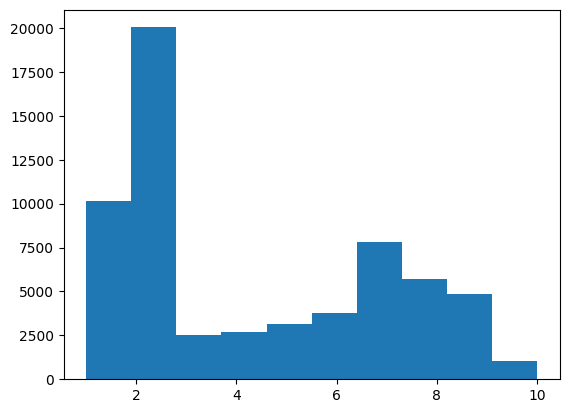

In [4]:
Medallion = dump.copy(True)


Medallion["Married"] = Medallion["RELATION"].apply(lambda x: 1 if x in [1,2,3,4] else 0)
Medallion["Parent"] = Medallion["RELATION"].apply(lambda x: 1 if x in [5,6] else 0)
Medallion["Child"] = Medallion["RELATION"].apply(lambda x: 1 if x in [7,8] else 0)
Medallion["Sibling"] = Medallion["RELATION"].apply(lambda x: 1 if x in [9,10] else 0)
Medallion["Other"] = Medallion["RELATION"].apply(lambda x: 1 if x in [16] else 0)

relations = Medallion.groupby("RELATION").count()["COUNT"]

plt.hist(Medallion[Medallion["RELATION"] <= 10 ]["RELATION"], 10)

In [5]:
# new granuality of data

# Cole's group by


# what we want to keep
groupby_cols = ["DATE", "IN_FAMILY", "KILLED_CHILD", "IN_CITY", "OFFRACE", "OFFSEX", "IN_RURAL"]
# groupby_cols = ["DATE", "IN_FAMILY", ]


drop_cols = [col for col in dump.columns if col not in groupby_cols] 
print("dropped cols" , drop_cols)

ts = dump.drop(columns=drop_cols, axis=1)

ts2 = ts


# maybe try not counting
ts = ts.groupby(groupby_cols)['DATE'].agg('count').to_frame("Counts").reset_index()
# ts['DATE'] = pd.to_datetime(ts['DATE'])
ts


start_date =  pd.to_datetime("1976-01-01")

# periods
ts['start_date'] = start_date
ts['PERIOD'] = (pd.to_datetime(ts['DATE']).dt.year - ts['start_date'].dt.year) * 12 + (pd.to_datetime(ts['DATE']).dt.month - ts['start_date'].dt.month)
# ts['period'] = (pd.to_datetime(ts['DATE']).dt.year - start_date.dt.year) * 12 + (ts.Date.dt.month - start_date.dt.month)

print(ts)


dropped cols ['MONTH', 'YEAR', 'VICSEX', 'VICRACE', 'RELATION', 'CIRCUM', 'POPGROUP', 'STCODE', 'DATE_and_STATE', 'COUNT', 'IN_SUBURB']
             DATE  IN_FAMILY  KILLED_CHILD  IN_CITY  OFFRACE  OFFSEX  \
0      1976-01-01          0             0        0        1       1   
1      1976-01-01          0             0        0        1       1   
2      1976-01-01          0             0        0        1       2   
3      1976-01-01          0             0        0        1       2   
4      1976-01-01          0             0        0        2       1   
...           ...        ...           ...      ...      ...     ...   
17643  2003-12-01          1             1        0        2       2   
17644  2003-12-01          1             1        1        1       1   
17645  2003-12-01          1             1        1        1       2   
17646  2003-12-01          1             1        1        2       1   
17647  2003-12-01          1             1        1        2       2   


In [6]:

# make both dates same type before merge

unemployment['DATE'] = pd.to_datetime(unemployment['DATE'])
ts['DATE'] = pd.to_datetime(ts["DATE"])
ts2['DATE'] = pd.to_datetime(ts2["DATE"])

# add year only column for inflation merge
ts['YEAR'] = ts['DATE'].dt.year


In [7]:
# inflation data
inflation_df = pd.read_csv('../data/ECONOMIC/FPCPITOTLZGUSA.csv')
inflation_df['DATE'] = pd.to_datetime(inflation_df['DATE'])
inflation_df['YEAR'] = inflation_df['DATE'].dt.year
inflation_df.rename(columns={"FPCPITOTLZGUSA": "CPI"}, inplace=True)

In [8]:
# Merge on date
ts = ts.merge(unemployment, how="left", on='DATE')
ts2 = ts2.merge(unemployment, how="left", on='DATE')


ts = ts.merge(inflation_df, how='left', on='YEAR')

#ts.dropna(inplace=True)
# ts2.dropna(inplace=True)

## More complicated Reg

In [10]:
# DON'T MODIFY ts HERE

# drop any rows that are now infamily murders
reg_data = ts[ts['IN_FAMILY'] == 1]

x = reg_data[["UNRATE","OFFRACE", "OFFSEX", "IN_RURAL", 'PERIOD', "CPI"]]

print(ts2.columns)

x = sm.add_constant(x)

print(x)
y = (reg_data["Counts"])


sm.OLS(y, x).fit().summary()

Index(['OFFSEX', 'OFFRACE', 'DATE', 'IN_FAMILY', 'KILLED_CHILD', 'IN_CITY',
       'IN_RURAL', 'UNRATE'],
      dtype='object')
       const  UNRATE  OFFRACE  OFFSEX  IN_RURAL  PERIOD       CPI
23       1.0     7.9        1       1         0       0  5.744813
24       1.0     7.9        1       1         1       0  5.744813
25       1.0     7.9        1       2         0       0  5.744813
26       1.0     7.9        1       2         1       0  5.744813
27       1.0     7.9        2       1         0       0  5.744813
...      ...     ...      ...     ...       ...     ...       ...
17643    1.0     5.7        2       2         1     335  2.270095
17644    1.0     5.7        1       1         0     335  2.270095
17645    1.0     5.7        1       2         0     335  2.270095
17646    1.0     5.7        2       1         0     335  2.270095
17647    1.0     5.7        2       2         0     335  2.270095

[9467 rows x 7 columns]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Counts   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     229.8
Date:                Wed, 10 Apr 2024   Prob (F-statistic):          5.44e-275
Time:                        15:26:50   Log-Likelihood:                -35068.
No. Observations:                9467   AIC:                         7.015e+04
Df Residuals:                    9460   BIC:                         7.020e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0704      0.991     12.182      0.000      10.128      14.013
UNRATE         0.2319      0.096      2.421      0.015       0.044       0.420
OFFRACE       -1.2320      0.054    -22.692      0.000      -1.338      -1.126
OFFSEX        -0.7525      0.082     -9.129      0.000      -0.914      -0.591
IN_RURAL       2.0308      0.215      9.461      0.000       1.610       2.452
PERIOD        -0.0148      0.002     -7.820      0.000      -0.019      -0.011
CPI            0.0932      0.051      1.839      0.066      -0.006       0.193
==============================================================================
Omnibus:                     4187.546   Durbin-Watson:                   1.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19957.768
Skew:                           2.156   Prob(JB):                         0.00
Kurtosis:                       8.656   Cond. No.                     1.89e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Simple Reg : # of in family murders ~ inflation

In [12]:
# DON'T MODIFY ts HERE

# drop any rows that are now infamily murders
reg_data = ts[ts['IN_FAMILY'] == 1]

x = reg_data[['PERIOD', "CPI"]]
x = sm.add_constant(x)

y = (reg_data["Counts"])


sm.OLS(y, x).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Counts   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     134.7
Date:                Wed, 10 Apr 2024   Prob (F-statistic):           6.21e-31
Time:                        15:29:24   Log-Likelihood:                -35645.
No. Observations:                9467   AIC:                         7.129e+04
Df Residuals:                    9465   BIC:                         7.131e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1277      0.198     30.917      0.000       5.739       6.516
CPI            0.4261      0.037     11.606      0.000       0.354       0.498
==============================================================================
Omnibus:                     4639.338   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25344.160
Skew:                           2.379   Prob(JB):                         0.00
Kurtosis:                       9.451   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""